# 패션 MNIST 오토인코더 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

# 데이터 다운로드

In [5]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

# 학습 데이터를 랜덤하게 섞어서 레이블 순서를 추정하지 못하게 한다
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



In [6]:
# 데이터 확인
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


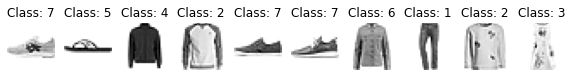

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

# AE 모델

In [8]:
class AE(nn.Module):    # nn.Module을 상속받는다
    def __init__(self): # 객체 생성시 수행되는 함수
        super(AE, self).__init__() # nn.Module 에 있는 메소드를 상속받아 사용한다
        
        self.encoder = nn.Sequential(  # 인코더를 정의하는 부분
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            # nn.Linear(512, 256),
            nn.Linear(512, 128),
            nn.ReLU(),
            # nn.Linear(256, 32),)    # 임베딩 벡터 크기: 32
            nn.Linear(128, 8),)    # 임베딩 벡터 크기: 8
        
        self.decoder = nn.Sequential(
            # nn.Linear(32, 256),
            nn.Linear(8, 128),
            nn.ReLU(),
            # nn.Linear(256, 512),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),)

    def forward(self, x): # 인코더와 디코더를 수행하는 코드
        encoded = self.encoder(x) # 잠재 벡터를 생성
        decoded = self.decoder(encoded) # 잠재 벡터를 디코더에 입력
        return encoded, decoded

## AE 모델의 출력과 레이블의 차이를 측정하는 손실함수로 MSE를 사용한다
- 즉, 얼마나 AE가 잘 동작하는지를 측정하는데 MSE 사용

In [9]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [10]:
def train(model, train_loader, optimizer, log_interval):
    model.train()   # 모델을 훈련 상태로 지정
    for batch_idx, (image, _) in enumerate(train_loader): # 레이블은 사용하지 않는다
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [11]:
# 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval() # 모델을 검증 상태로 지정
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():  # 그라디언트의 흐름을 억제
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.218704
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.028249
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.020573
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.019467
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.022089
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.017181
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.020233
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.016540
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.021360
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.018585

[EPOCH: 1], 	Test Loss: 0.0174


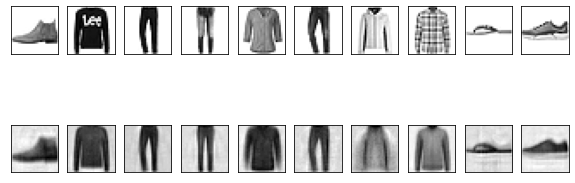

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.014111
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.018080
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.018474
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.017156
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.015604
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.014561
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.015899
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.016435
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.015592
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.013975

[EPOCH: 2], 	Test Loss: 0.0159


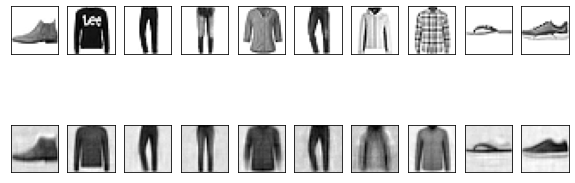

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.015907
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.016249
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.013668
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.014503
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.013064
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.015106
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.014190
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.016914
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.016191
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.013057

[EPOCH: 3], 	Test Loss: 0.0153


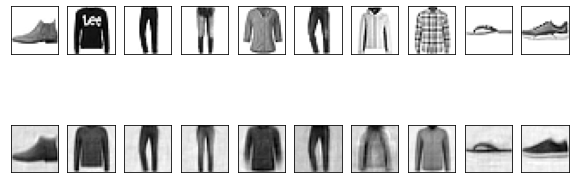

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.014623
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.016707
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.013751
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.020163
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.012557
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.016366
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.018361
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.019187
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.016533
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.014996

[EPOCH: 4], 	Test Loss: 0.0151


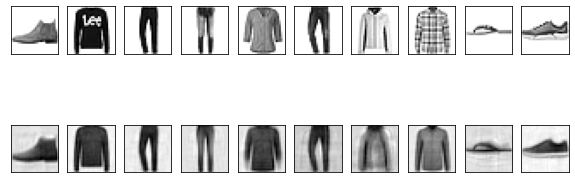

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.015496
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.015742
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.010276
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.012702
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.015385
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.015831
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.015310
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.017783
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.011967
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.012746

[EPOCH: 5], 	Test Loss: 0.0146


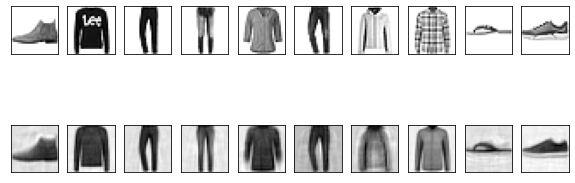

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.014900
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.011288
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.014204
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.012622
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.016120
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.015625
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.016783
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.010841
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.013693
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.015334

[EPOCH: 6], 	Test Loss: 0.0146


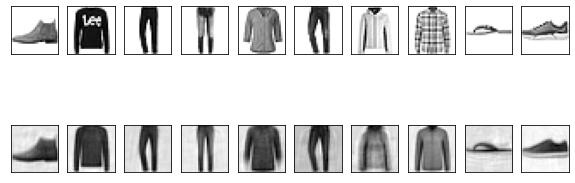

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.014336
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.016596
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.015762
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.014035
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.017699
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.014810
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.013366
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.013247
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.014287
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.017137

[EPOCH: 7], 	Test Loss: 0.0146


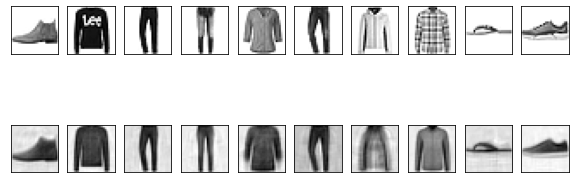

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.014569
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.012780
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.014783
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.012226
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.012372
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.012470
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.015457
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.015573
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.011775
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.013633

[EPOCH: 8], 	Test Loss: 0.0143


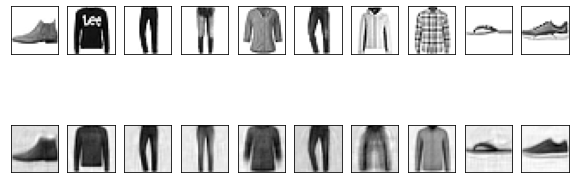

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.015056
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.013434
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.014609
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.013881
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.014327
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.016368
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.013543
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.015041
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.014745
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.016225

[EPOCH: 9], 	Test Loss: 0.0141


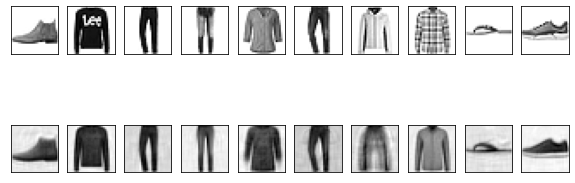

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.014263
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.012465
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.016953
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.013431
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.012549
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.012245
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.011804
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.016548
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.012141
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.014053

[EPOCH: 10], 	Test Loss: 0.0141


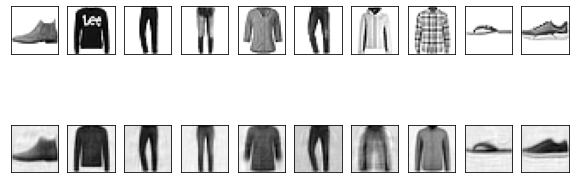

In [12]:
# 학습 실행
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()